In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
#import matplotlib.font_manager as fm
import matplotlib
import autotime
%matplotlib inline
%load_ext autotime
#import seaborn as sns
import statsmodels as stm
import statsmodels.formula.api as sm
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics
from sklearn.linear_model import LinearRegression as LinR
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV as RSCV
from dask_searchcv import RandomizedSearchCV as DRSCV
from sklearn.pipeline import Pipeline
from sklearn.metrics.scorer import make_scorer

#from sklearn.tree import export_graphviz
#from IPython.display import Image

In [2]:
# setting variables

cores = 3
SSIDno = 9090786

time: 2 ms


## 1. Data processing stage

First, select route files to input based on SSIDno to analyse

### 1a Inputting data and creating dataframe for SSIDno

In [3]:
# Read in stop_times.txt and trips.txt files from NTA data
stop_times_2012 = pd.read_csv('stop_times.txt')
trips_2012 = pd.read_csv('trips.txt')

# Merge by trip_id
merge = pd.merge(stop_times_2012, trips_2012, on='trip_id', how='outer')

# Keep only necessary columns
merge.drop(['arrival_time','departure_time','pickup_type','drop_off_type','service_id','shape_dist_traveled'], axis=1, inplace=True)

# Transform trip_id to route and stop_id to StopID
merge['route_short'] = merge['trip_id'].apply(lambda x: x[x.index('-')+1:])
merge['route_short'] = merge['route_short'].apply(lambda x: x[: x.index('-')])
merge['route_short'] = merge['route_short'].apply(lambda x: str(x).zfill(4))
merge['StopID'] = merge['stop_id'].apply(lambda x: x[-4:])

# Find StopID and the sequence of that shape_id
gb = merge.groupby(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'])
gbc = gb.count()
gbc.reset_index(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'], inplace=True)
transit_shapeID_stopID = gbc.drop(['trip_id','stop_id','route_id','trip_headsign'], axis=1)

# create list of pairs of routes and the SSIDs contained within them
ssid = []
for i in range(len(transit_shapeID_stopID.index)-1):
    temp = transit_shapeID_stopID['StopID'].iloc[i] + transit_shapeID_stopID['StopID'].iloc[i+1]
    ssid.append([ transit_shapeID_stopID['route_short'].iloc[i],temp])
    
SSIDnoStr = str(SSIDno).zfill(8)
routes = [x for x in ssid if SSIDnoStr in x[1]]
routes = [item[0] for item in routes]
routes = list(set(routes))

# Reading in the route CSV files for the required SSID

res = pd.read_csv('Route_XXXX_travel_time_csvs/Blank_Route_travel_time.csv')
route_list = routes
for r in route_list:
    df = pd.read_csv('Route_XXXX_travel_time_csvs/Route_%s_travel_time.csv' % r)
    res = pd.concat([df, res], axis=0) 

time: 8.01 s


In [4]:
# create dataframe for SSIDno

res['SSID'] = res['SSID'].astype('category')
ssid_df = res[res.SSID == SSIDno]
ssid_df.reset_index(inplace=True)
ssid_df = ssid_df.drop('index', axis=1)
ssid_df.shape

(12986, 12)

time: 154 ms


In [5]:
ssid_df.memory_usage(deep=True)

Index                   80
Day                 834207
DestStopID          103888
HourFrame           103888
JourneyPatternID    656228
Rain                103888
SSID                224428
SchoolHoliday        12986
SourceStopID        103888
TimeFrame           870062
TravelTime          103888
VehicleJourneyID    103888
WindSpeed           103888
dtype: int64

time: 7 ms


In [6]:
# add leading zeroes to JourneyPatternID

ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.astype('object')
ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.apply(lambda x: str(x).zfill(8))

time: 11 ms


### 1b Adding extra features and altering/dropping existing ones

In [7]:
# adding Xbuses feature - boolean feature indicating whether or not the JourneyPatternID represents an express (X) bus

ssid_df['XBuses'] = ssid_df[ssid_df["JourneyPatternID"].str.find("X") > 0].sum(axis=1) > 0
ssid_df["XBuses"].fillna(False, inplace=True)
ssid_df['XBuses'] = ssid_df['XBuses'].astype('int')

time: 16 ms


In [8]:
# adding JPID_length feature - represents the total number of stops traversed by this JourneyPatternID along its entire route

JPIDL = pd.read_csv('JPID_Length.csv')
JPIDL = JPIDL.drop('Unnamed: 0', axis=1)
ssid_df = pd.merge(left=ssid_df ,right=JPIDL, how='left', left_on='JourneyPatternID', right_on='JourneyPatternID')
ssid_df = ssid_df.dropna()
ssid_df.shape

(12986, 14)

time: 19 ms


In [9]:
# NOTE: feature currently not being used due to issues with inputting it to the model

# adding JPID_Freq feature - represents how often in the given data this JourneyPatternID traversed this segment

# ssid_df['JPID_Freq'] = ssid_df.groupby(['JourneyPatternID'])['JourneyPatternID'].transform('count')

time: 1 ms


In [10]:
# removing non-holiday-period weekends from SchoolHoliday feature to avoid multi-collinearity issues

ssid_df['SchoolHoliday'] = ssid_df['SchoolHoliday'].astype('int')
ssid_df['SchoolHoliday'] = np.where(ssid_df['TimeFrame'].isin(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05', '2013-01-06']), 1, 0)

time: 4 ms


In [11]:
# fetching SSID number from dataframe for CSV file naming purposes

res.SSID = res.SSID.apply(lambda x: str(int(x)).zfill(8))
r = ssid_df.loc[0, 'SSID'] 

time: 16 ms


In [12]:
# dropping unneeded columns

ssid_df = ssid_df.drop(['SourceStopID', 'DestStopID', 'VehicleJourneyID', 'JourneyPatternID', 'SSID'], axis=1)

# reordering remaining columns

ssid_df = ssid_df[['TravelTime', 'Rain', 'WindSpeed', 'JPID_length', 'XBuses', 'SchoolHoliday', 'Day', 'HourFrame']]

time: 5 ms


In [13]:
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,XBuses,SchoolHoliday,Day,HourFrame
0,21,0.000000,15.0,55,0,0,Tuesday,8
1,100,0.000000,14.5,55,0,0,Wednesday,8
2,101,0.000000,12.5,55,0,0,Thursday,7
3,37,0.566667,16.0,55,0,0,Friday,8
4,39,0.266667,12.5,55,0,0,Monday,8
5,59,0.000000,17.0,55,0,0,Tuesday,8
6,80,0.000000,10.5,55,0,0,Wednesday,8
7,79,0.000000,3.5,55,0,0,Thursday,8
8,42,0.000000,3.0,55,0,0,Friday,8
9,60,0.000000,20.5,55,0,0,Monday,8


time: 25 ms


In [14]:
# assigning appropriate datatypes where necessary

ssid_df['Day'] = ssid_df['Day'].astype('category')
ssid_df['HourFrame'] = ssid_df['HourFrame'].astype('category')
ssid_df['JPID_length'] = ssid_df['JPID_length'].astype('int')

time: 32 ms


In [15]:
# removing any constant features
# code from: https://stackoverflow.com/questions/20209600/panda-dataframe-remove-constant-column

ssid_df = ssid_df.loc[:,ssid_df.apply(pd.Series.nunique) != 1]

time: 11 ms


In [16]:
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,XBuses,SchoolHoliday,Day,HourFrame
0,21,0.000000,15.0,55,0,0,Tuesday,8
1,100,0.000000,14.5,55,0,0,Wednesday,8
2,101,0.000000,12.5,55,0,0,Thursday,7
3,37,0.566667,16.0,55,0,0,Friday,8
4,39,0.266667,12.5,55,0,0,Monday,8
5,59,0.000000,17.0,55,0,0,Tuesday,8
6,80,0.000000,10.5,55,0,0,Wednesday,8
7,79,0.000000,3.5,55,0,0,Thursday,8
8,42,0.000000,3.0,55,0,0,Friday,8
9,60,0.000000,20.5,55,0,0,Monday,8


time: 24 ms


In [17]:
# save as csv

ssid_df.to_csv('SSID_CSVs/SSID_%s.csv' % r)

time: 70 ms


## 1c. Dropping Outliers

Visualising range of data first

Histiogram of values (x-axis is number of seconds)

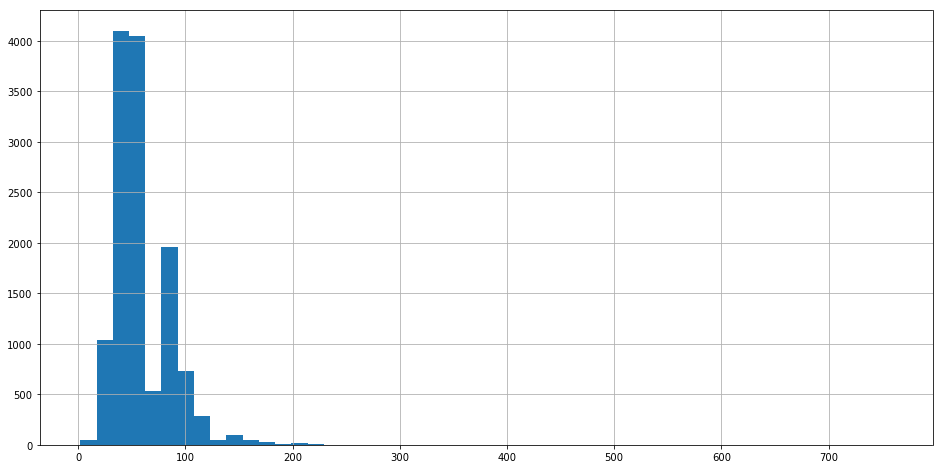

time: 231 ms


In [18]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

Boxplot to check for outliers

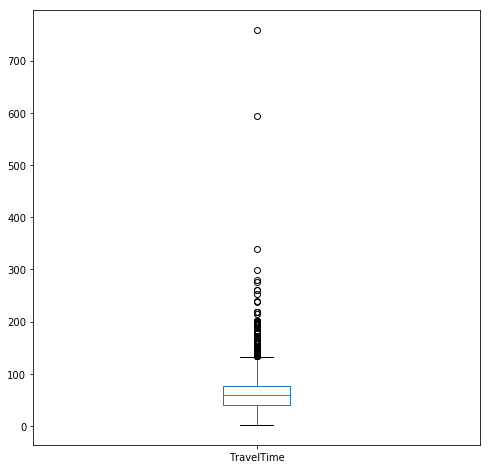

time: 179 ms


In [19]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

In [20]:
# Checking stats for TravelTime

ssid_df.TravelTime.describe()

count    12986.000000
mean        59.226706
std         27.661573
min          2.000000
25%         40.000000
50%         59.000000
75%         77.000000
max        759.000000
Name: TravelTime, dtype: float64

time: 6 ms


Dropping outliers

In [21]:
# loading table of minimum times to traverse segments at 65kmph

find_lb = pd.read_csv('use_speed_and_distance_get_outlier_bound.csv')

# extracting value for this segment, to use as lower bound for outlier removal

lb = find_lb.loc[find_lb['SSID'] == SSIDno, 'min_sec'].iloc[0]
print(lb)

14.5378563877
time: 11 ms


In [22]:
# make a copy of original df

trimssid_df = ssid_df.copy()

# Remove TravelTime upper bound outliers beyond a conservative 2 x IQR, and lowerbound below 'lb'

ub = trimssid_df.quantile(q=.75) + (2*(trimssid_df.quantile(q=.75)-trimssid_df.quantile(q=.25)))
trimssid_df['OutlierTT'] = (trimssid_df['TravelTime'] < lb) | (trimssid_df['TravelTime'] > ub['TravelTime'])

# Outlier rows counted

print("There will be", trimssid_df[(trimssid_df['OutlierTT'] == True)].shape[0], "outliers dropped.")

There will be 131 outliers dropped.
time: 12 ms


In [23]:
# dropping outliers

trimssid_df = trimssid_df[trimssid_df.OutlierTT != True]
trimssid_df.sort_values(['TravelTime'], ascending=False, inplace=True)
trimssid_df = trimssid_df.drop(['OutlierTT'], axis=1)
trimssid_df.reset_index(inplace=True)
trimssid_df = trimssid_df.drop('index', axis=1)
trimssid_df

,TravelTime,Rain,WindSpeed,JPID_length,XBuses,SchoolHoliday,Day,HourFrame
0,150,0.000000,9.5,55,0,0,Thursday,8
1,149,0.000000,4.0,63,0,1,Saturday,23
2,149,0.000000,27.0,71,0,0,Tuesday,15
3,148,0.000000,10.5,63,0,0,Friday,17
4,148,0.000000,9.5,35,0,0,Thursday,8
5,145,0.000000,2.5,38,1,0,Wednesday,14
6,145,0.000000,4.5,71,0,0,Thursday,11
7,145,0.199951,11.5,63,0,0,Tuesday,10
8,145,0.000000,7.0,38,1,0,Tuesday,8
9,144,0.000000,10.5,71,0,0,Friday,17


time: 60 ms


In [24]:
# Create TT mean/median value variables, to use in calculating mean/median absolute percentage accuracy scores
# and for horizontal lines in the charts below to represent the mean/medium

ssid_df = trimssid_df
ssid_df_mean = ssid_df.TravelTime.mean()
ssid_df_median  = ssid_df.TravelTime.median()
ssid_df.TravelTime.describe()

count    12855.000000
mean        58.150292
std         23.791611
min         15.000000
25%         40.000000
50%         59.000000
75%         76.000000
max        150.000000
Name: TravelTime, dtype: float64

time: 6 ms


Bocplot post-outlier dropping

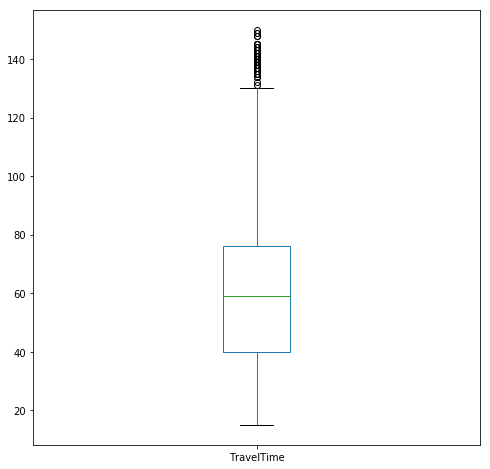

time: 174 ms


In [25]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

## 2. Visualising the data

### 2ai Bar plot for mean TravelTime per HourFrame

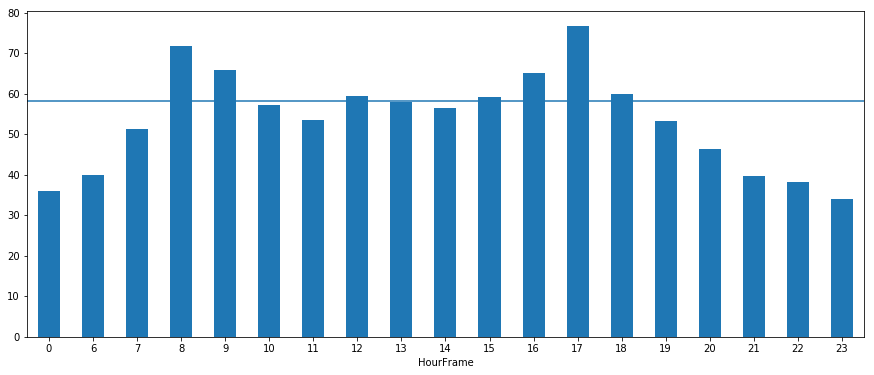

time: 186 ms


In [26]:
mean_HF = ssid_df.groupby('HourFrame')['TravelTime'].mean()
mean_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2aii Bar plot for median TravelTime per HourFrame

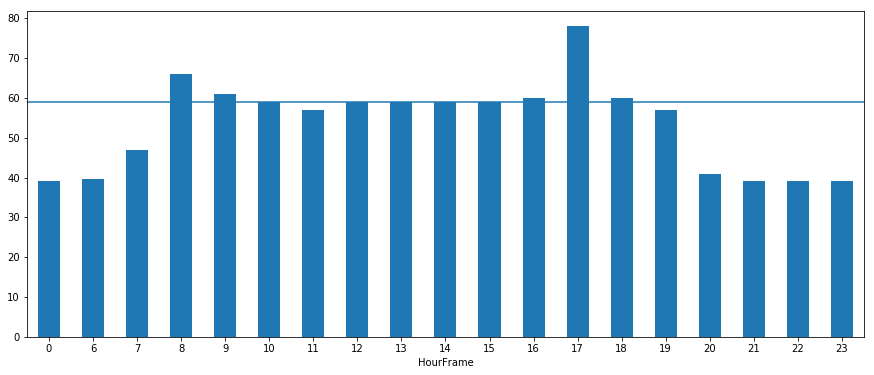

time: 185 ms


In [27]:
med_HF = ssid_df.groupby('HourFrame')['TravelTime'].median()
med_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  Busy at rush-hour, especially the evening.  At or above median most of the day, drops off after 7pm and up until 7am.

### 2bi Bar plot for mean TravelTime per Day

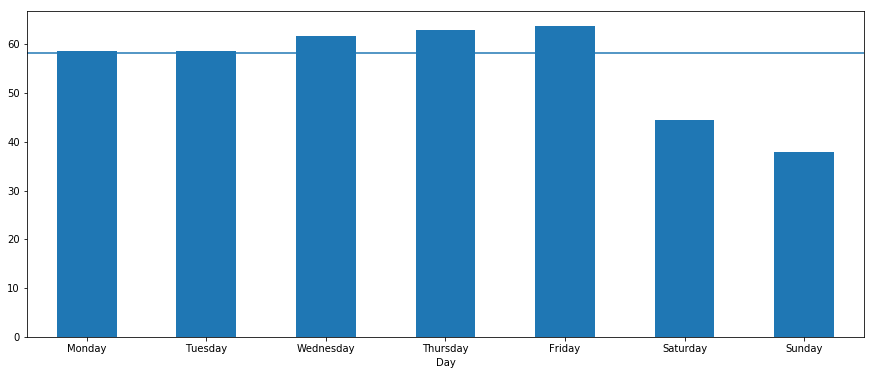

time: 143 ms


In [28]:
mean_Day = ssid_df.groupby('Day')['TravelTime'].mean()
mean_Day=mean_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

mean_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean

coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2bii Bar plot for median TravelTime per HourFrame

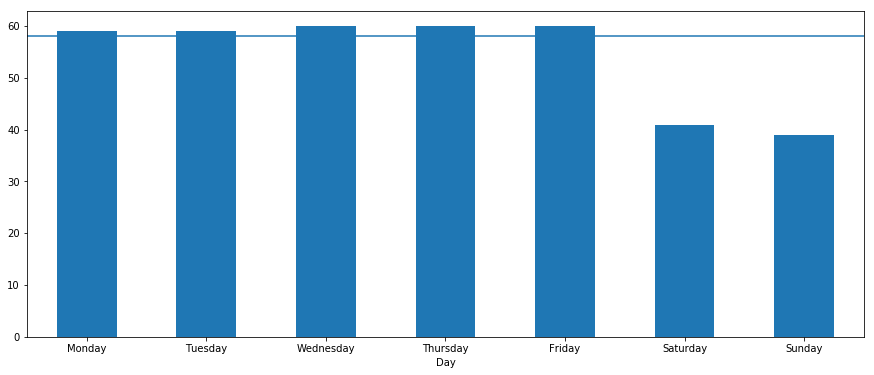

time: 141 ms


In [29]:
med_Day = ssid_df.groupby('Day')['TravelTime'].median()

med_Day=med_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
med_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  Weekdays at median or above, slight increase as the week goes on.  A good third or so quieter on weekends, more pronounced on Sunday.

### 2ci Bar plot for mean TravelTime when SchoolHoliday true/false

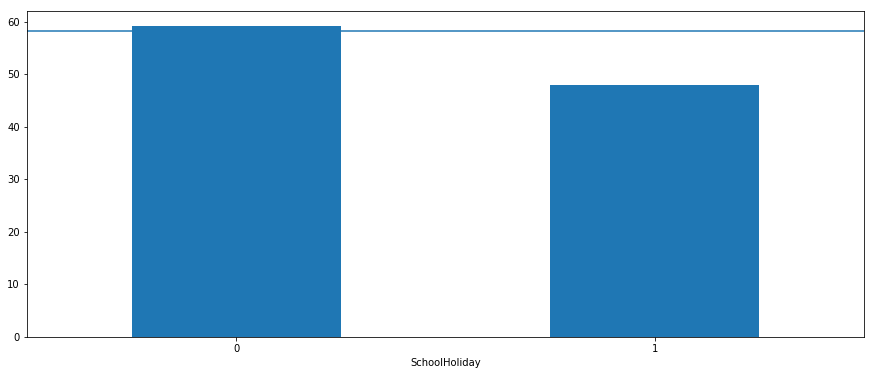

time: 123 ms


In [30]:
mean_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].mean()
mean_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2cii Bar plot for median TravelTime when SchoolHoliday true/false

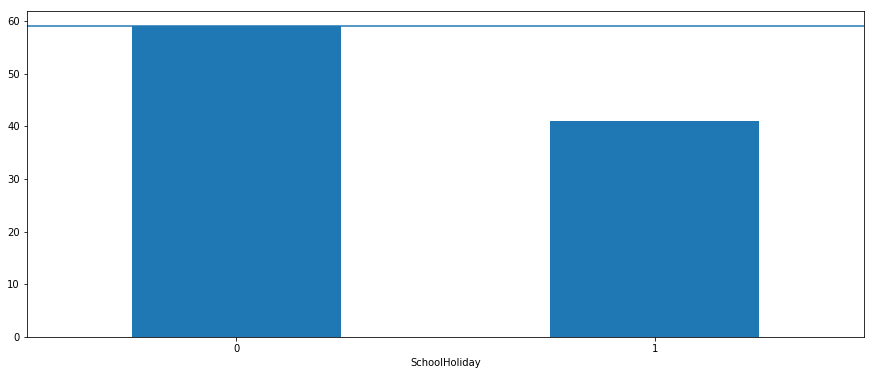

time: 122 ms


In [31]:
med_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].median()
med_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Splitting data into 70% for training and 30% for testing

## 3 Model training (Scikit-learn)

First we need to dreate dummy variables for categorical features, and split into test and training sets

### 3.1 Prepare data for modelling via Scikit-learn

In [32]:
# create dummy variables from HourFrame and Day using get_dummies
# dropping first values to avoid multicollinearity (Day = Friday, Hour = 0 or 6 or 7, depending on SSID)

Day_dummies = pd.get_dummies(ssid_df.Day, prefix='Day', drop_first=True)
HF_dummies = pd.get_dummies(ssid_df.HourFrame, prefix='HF', drop_first=True)

# concatenate the dummy variable columns onto the original DataFrame and drop the original features
ssid_df = pd.concat([ssid_df, HF_dummies, Day_dummies], axis=1)
ssid_df = ssid_df.drop(['HourFrame', 'Day'], axis=1)
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,XBuses,SchoolHoliday,HF_6,HF_7,HF_8,HF_9,...,HF_20,HF_21,HF_22,HF_23,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,150,0.000000,9.5,55,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,149,0.000000,4.0,63,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,149,0.000000,27.0,71,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,148,0.000000,10.5,63,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,148,0.000000,9.5,35,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5,145,0.000000,2.5,38,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,145,0.000000,4.5,71,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,145,0.199951,11.5,63,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,145,0.000000,7.0,38,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
9,144,0.000000,10.5,71,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


time: 89 ms


In [33]:
# prepare a list containing all remaining features bar the target
pred_features = list(ssid_df)
pred_features.remove('TravelTime')
print(pred_features)

['Rain', 'WindSpeed', 'JPID_length', 'XBuses', 'SchoolHoliday', 'HF_6', 'HF_7', 'HF_8', 'HF_9', 'HF_10', 'HF_11', 'HF_12', 'HF_13', 'HF_14', 'HF_15', 'HF_16', 'HF_17', 'HF_18', 'HF_19', 'HF_20', 'HF_21', 'HF_22', 'HF_23', 'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday']
time: 2 ms


In [34]:
# prepare target/predictive feature variables for use in scikit-learn modelling

X = ssid_df[pred_features]
y = ssid_df['TravelTime']

time: 3 ms


In [35]:
# split the data into training portion (70%) and final testing potion (30%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 38)

time: 6 ms


### 3bi Linear Regression model (via scikit-learn) - training - default parameters

In [36]:
lr = LinR(n_jobs = cores)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=3, normalize=False)

time: 11 ms


In [37]:
lr_pred = lr.predict(X_train)
lr_rsq = metrics.r2_score(y_train, lr_pred)
print ("The R-squared value of the Linear Regression model is", lr_rsq)

The R-squared value of the Linear Regression model is 0.300201699424
time: 5 ms


In [38]:
lr_mae = metrics.mean_absolute_error(y_train, lr_pred)
print ("The mean absolute error of the Linear Regression model is", lr_mae)
print ("The mean absolute percentage accuracy is", (((ssid_df_mean-lr_mae)/ssid_df_mean)*100))

The mean absolute error of the Linear Regression model is 15.1475983494
The mean absolute percentage accuracy is 73.9509503692
time: 5 ms


In [39]:
lr_mdae = metrics.median_absolute_error(y_train, lr_pred)
print ("The median absolute error of the Linear Regression model is", lr_mdae)
print ("The median absolute percentage accuracy is", (((ssid_df_median-lr_mdae)/ssid_df_median)*100))

The median absolute error of the Linear Regression model is 12.5068273208
The median absolute percentage accuracy is 78.8019875919
time: 6 ms


### 3bii Linear Regression model (via scikit-learn) - testing - default parameters

In [40]:
lr_preda = lr.predict(X_test)
lr_rsqa = metrics.r2_score(y_test, lr_preda)
print ("The R-squared value of the Linear Regression model is", lr_rsqa)

The R-squared value of the Linear Regression model is 0.305053021381
time: 5 ms


In [41]:
lr_maea = metrics.mean_absolute_error(y_test, lr_preda)
print ("The mean absolute error of the Linear Regression model is", lr_maea)
print ("The mean absolute percentage accuracy is", (((ssid_df_mean-lr_maea)/ssid_df_mean)*100))

The mean absolute error of the Linear Regression model is 15.3279830042
The mean absolute percentage accuracy is 73.6407461561
time: 5 ms


In [42]:
lr_mdaea = metrics.median_absolute_error(y_test, lr_preda)
print ("The median absolute error of the Linear Regression model is", lr_mdaea)
print ("The median absolute percentage accuracy is", (((ssid_df_median-lr_mdaea)/ssid_df_median)*100))

The median absolute error of the Linear Regression model is 13.012054428
The median absolute percentage accuracy is 77.945670461
time: 6 ms


### 3ci Support Vector Machine Regression with RBF Kernel model - training - default parameters

In [43]:
svr_rbf = SVR(kernel='rbf')
svr_rbf.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

time: 4.44 s


In [44]:
svr_rbf_pred = svr_rbf.predict(X_train)
svr_rbf_rsq = metrics.r2_score(y_train, svr_rbf_pred)
print ("The R-squared value of the SVR with RBF Kernel model is", svr_rbf_rsq)

The R-squared value of the SVR with RBF Kernel model is 0.129963091719
time: 3.04 s


In [45]:
svr_rbf_mae = metrics.mean_absolute_error(y_train, svr_rbf_pred)
print ("The mean absolute error of the SVR with RBF Kernel model is", svr_rbf_mae)
print ("The mean absolute percentage accuracy is", (((ssid_df_mean-svr_rbf_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with RBF Kernel model is 16.478551457
The mean absolute percentage accuracy is 71.6621344951
time: 2 ms


In [46]:
svr_rbf_mdae = metrics.median_absolute_error(y_train, svr_rbf_pred)
print ("The median absolute error of the SVR with RBF Kernel model is", svr_rbf_mdae)
print ("The median absolute percentage accuracy is", (((ssid_df_median-svr_rbf_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with RBF Kernel model is 15.5006866739
The median absolute percentage accuracy is 73.7276497052
time: 3 ms


### 3cii Support Vector Machine Regression with RBF Kernel model - testing - default parameters

In [47]:
svr_rbf_preda = svr_rbf.predict(X_test)
svr_rbf_rsqa = metrics.r2_score(y_test, svr_rbf_preda)
print ("The R-squared value of the SVR with RBF Kernel model is", svr_rbf_rsqa)

The R-squared value of the SVR with RBF Kernel model is 0.12088595135
time: 1.29 s


In [48]:
svr_rbf_maea = metrics.mean_absolute_error(y_test, svr_rbf_preda)
print ("The mean absolute error of the SVR with RBF Kernel model is", svr_rbf_maea)
print ("The mean absolute percentage accuracy is", (((ssid_df_mean-svr_rbf_maea)/ssid_df_mean)*100))

The mean absolute error of the SVR with RBF Kernel model is 16.959358104
The mean absolute percentage accuracy is 70.835300041
time: 2 ms


In [49]:
svr_rbf_mdaea = metrics.median_absolute_error(y_test, svr_rbf_preda)
print ("The median absolute error of the SVR with RBF Kernel model is", svr_rbf_mdaea)
print ("The median absolute percentage accuracy is", (((ssid_df_median-svr_rbf_mdaea)/ssid_df_median)*100))

The median absolute error of the SVR with RBF Kernel model is 15.9004427433
The median absolute percentage accuracy is 73.0500970452
time: 3 ms


### 3di Gradient Boosting Regression model - training - default parameters

In [50]:
gbr = GBR()
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

time: 443 ms


In [51]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
Day_Sunday 	 0.0948293028592
Day_Saturday 	 0.0903918007187
WindSpeed 	 0.0776362464235
HF_23 	 0.0644304913267
HF_21 	 0.0601151856208
HF_22 	 0.0566296175624
HF_17 	 0.0548259436353
SchoolHoliday 	 0.0525448587077
HF_20 	 0.0458031444779
HF_6 	 0.0455123519683
JPID_length 	 0.0436715568375
Rain 	 0.041649663905
Day_Tuesday 	 0.0395159255071
HF_7 	 0.0356447157774
HF_9 	 0.03480591937
HF_16 	 0.0280717775819
HF_8 	 0.0279022269961
Day_Monday 	 0.0238460373194
HF_11 	 0.0172128132074
HF_19 	 0.0167838247929
XBuses 	 0.0134646969998
HF_15 	 0.00893408393634
Day_Thursday 	 0.00690031601374
HF_12 	 0.00676837786839
HF_18 	 0.00575271497282
HF_10 	 0.00380382321817
HF_14 	 0.00232268996343
Day_Wednesday 	 0.000165790741013
HF_13 	 6.4101691118e-05
time: 67 ms


In [52]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
print ("The R-squared value of the Gradient Boosting Regression model is", gbr_rsq)

The R-squared value of the Gradient Boosting Regression model is 0.330198896697
time: 14 ms


In [53]:
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
print ("The mean absolute error of the Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage accuracy is", (((ssid_df_mean-gbr_mae)/ssid_df_mean)*100))

The mean absolute error of the Gradient Boosting Regression model is 14.6502190196
The mean absolute percentage accuracy is 74.8062845646
time: 3 ms


In [54]:
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The median absolute error of the Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage accuracy is", (((ssid_df_median-gbr_mdae)/ssid_df_median)*100))

The median absolute error of the Gradient Boosting Regression model is 11.8249551577
The median absolute percentage accuracy is 79.9577031226
time: 5 ms


### 3dii Gradient Boosting Regression model - - testing - default parameters

In [55]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
print ("The R-squared value of the Gradient Boosting Regression model is", gbr_rsqa)

The R-squared value of the Gradient Boosting Regression model is 0.323627024108
time: 9 ms


In [56]:
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
print ("The mean absolute error of the Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage accuracy is", (((ssid_df_mean-gbr_maea)/ssid_df_mean)*100))

The mean absolute error of the Gradient Boosting Regression model is 14.974736327
The mean absolute percentage accuracy is 74.248218048
time: 3 ms


In [57]:
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The median absolute error of the Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage accuracy is", (((ssid_df_median-gbr_mdaea)/ssid_df_median)*100))

The median absolute error of the Gradient Boosting Regression model is 12.4847076327
The median absolute percentage accuracy is 78.8394785887
time: 2 ms


### 3ei Random Forest Regression model (all default) - training - default parameters

In [58]:
rfr = RFR(n_jobs = cores)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=3, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

time: 114 ms


In [59]:
indices = np.argsort(rfr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", rfr.feature_importances_[indices[f]])

Ordered feature ranking:
WindSpeed 	 0.196721658176
JPID_length 	 0.149660256104
Day_Sunday 	 0.0759613149401
HF_17 	 0.073720806469
Day_Saturday 	 0.0650102312393
HF_8 	 0.0529237210802
Rain 	 0.0516660617629
HF_23 	 0.0375937299314
HF_21 	 0.0317799150332
SchoolHoliday 	 0.030448473209
HF_22 	 0.025130520872
Day_Thursday 	 0.0212749934021
Day_Wednesday 	 0.0195574683235
Day_Tuesday 	 0.0193399881099
HF_9 	 0.0193255098049
HF_16 	 0.0182714495927
HF_20 	 0.0137044608798
Day_Monday 	 0.0126741817966
XBuses 	 0.0125166735743
HF_6 	 0.0118930232714
HF_12 	 0.00802550068742
HF_7 	 0.00794371703888
HF_19 	 0.00761963964867
HF_14 	 0.00717544308479
HF_15 	 0.00662492563672
HF_13 	 0.00644090717564
HF_10 	 0.00619412222172
HF_18 	 0.00552366531286
HF_11 	 0.00527764162089
time: 3.05 s


In [60]:
rfr_pred = rfr.predict(X_train)
rfr_rsq = metrics.r2_score(y_train, rfr_pred)
print ("The R-squared value of the Random Forest Regression model is", rfr_rsq)

The R-squared value of the Random Forest Regression model is 0.551246018924
time: 106 ms


In [61]:
rfr_mae = metrics.mean_absolute_error(y_train, rfr_pred)
print ("The mean absolute error of the Random Forest Regression model is", rfr_mae)
print ("The mean absolute percentage accuracy is", (((ssid_df_mean-rfr_mae)/ssid_df_mean)*100))

The mean absolute error of the Random Forest Regression model is 11.7744184575
The mean absolute percentage accuracy is 79.7517465344
time: 2 ms


In [62]:
rfr_mdae = metrics.median_absolute_error(y_train, rfr_pred)
print ("The median absolute error of the Random Forest Regression model is", rfr_mdae)
print ("The median absolute percentage accuracy is", (((ssid_df_median-rfr_mdae)/ssid_df_median)*100))

The median absolute error of the Random Forest Regression model is 9.12348137973
The median absolute percentage accuracy is 84.5364722377
time: 5 ms


### 3eii Random Forest Regression model (all default) - testing - default parameters

In [63]:
rfr_preda = rfr.predict(X_test)
rfr_rsqa = metrics.r2_score(y_test, rfr_preda)
print ("The R-squared value of the Random Forest Regression model is", rfr_rsqa)

The R-squared value of the Random Forest Regression model is 0.200753308203
time: 106 ms


In [64]:
rfr_maea = metrics.mean_absolute_error(y_test, rfr_preda)
print ("The mean absolute error of the Random Forest Regression model is", rfr_maea)
print ("The mean absolute percentage accuracy is", (((ssid_df_mean-rfr_mae)/ssid_df_mean)*100))

The mean absolute error of the Random Forest Regression model is 16.4891510797
The mean absolute percentage accuracy is 79.7517465344
time: 2 ms


In [65]:
rfr_mdaea = metrics.median_absolute_error(y_test, rfr_preda)
print ("The median absolute error of the Random Forest Regression model is", rfr_mdaea)
print ("The median absolute percentage accuracy is", (((ssid_df_median-rfr_mdaea)/ssid_df_median)*100))

The median absolute error of the Random Forest Regression model is 13.6933333333
The median absolute percentage accuracy is 76.790960452
time: 3 ms


## 4 All models bar Linear Regression - parameter tuning with RandomizedSearchCV

### 4ai SVR with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

In [66]:
svr = SVR()

param_svr = {'epsilon': [0, 2],
        'C': [1, 100],      
        'gamma': [0, 50]}

time: 1e+03 µs


In [67]:
svr_rsearch_sk = RSCV(svr, param_distributions = param_svr, n_iter = 5, cv = 5, n_jobs = -1, scoring = make_scorer(metrics.median_absolute_error))
svr_rsearch_sk.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=5, n_jobs=-1,
          param_distributions={'epsilon': [0, 2], 'C': [1, 100], 'gamma': [0, 50]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True,
          scoring=make_scorer(median_absolute_error), verbose=0)

time: 52.5 s


In [68]:
print("Best estimator found:")
print(svr_rsearch_sk.best_estimator_)

Best estimator found:
SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0, gamma=0,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
time: 1e+03 µs


In [69]:
print("Best parameters set found:")
print(svr_rsearch_sk.best_params_)

Best parameters set found:
{'gamma': 0, 'epsilon': 0, 'C': 100}
time: 3 ms


In [70]:
print("Best score found:")
print(svr_rsearch_sk.best_score_)

Best score found:
18.4000889086
time: 2 ms


In [71]:
print("All scores found:")
print(svr_rsearch_sk.cv_results_)

All scores found:
{'split0_test_score': array([ 18.        ,  18.        ,  17.0001128 ,  16.87145742,  16.99975921]), 'split1_test_score': array([ 19.        ,  19.        ,  17.00028882,  16.70760198,  17.24952018]), 'split2_test_score': array([ 19.        ,  19.        ,  17.00017719,  16.48963221,  17.397448  ]), 'split3_test_score': array([ 18.        ,  18.        ,  17.00023791,  16.62764803,  17.00025981]), 'split4_test_score': array([ 18.        ,  18.        ,  17.00017036,  16.9029775 ,  16.4096474 ]), 'mean_test_score': array([ 18.40008891,  18.40008891,  17.00019741,  16.71985333,  17.01139502]), 'std_test_score': array([  4.89916089e-01,   4.89916089e-01,   6.04940436e-05,
         1.53736689e-01,   3.37053431e-01]), 'rank_test_score': array([1, 1, 4, 5, 3]), 'split0_train_score': array([ 18.        ,  18.        ,   1.99988543,   2.00060331,  16.32200489]), 'split1_train_score': array([ 18.        ,  18.        ,   1.99971292,   2.0005665 ,  16.24951971]), 'split2_train_

In [72]:
# testing this, deprecated
print("All scores found:")
print(svr_rsearch_sk.grid_scores_)

All scores found:
[mean: 18.40009, std: 0.48990, params: {'gamma': 0, 'epsilon': 0, 'C': 100}, mean: 18.40009, std: 0.48990, params: {'gamma': 0, 'epsilon': 0, 'C': 1}, mean: 17.00020, std: 0.00006, params: {'gamma': 50, 'epsilon': 0, 'C': 100}, mean: 16.71985, std: 0.15373, params: {'gamma': 50, 'epsilon': 2, 'C': 100}, mean: 17.01140, std: 0.33708, params: {'gamma': 50, 'epsilon': 2, 'C': 1}]
time: 2 ms


C:\CS\Anaconda\envs\DublinBus\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


### 4aii SVR with RandomizedSearchCV (dask), Kfold 5, 5 iterations

In [73]:
svr_rsearch_dk = DRSCV(svr, param_distributions = param_svr, n_iter = 5, cv = 5, scoring = make_scorer(metrics.median_absolute_error))
svr_rsearch_dk.fit(X_train, y_train)

RandomizedSearchCV(cache_cv=True, cv=5, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          iid=True, n_iter=5, n_jobs=-1,
          param_distributions={'epsilon': [0, 2], 'C': [1, 100], 'gamma': [0, 50]},
          random_state=None, refit=True, return_train_score=True,
          scheduler=None, scoring=make_scorer(median_absolute_error))

time: 40.2 s


In [74]:
print("Best estimator found:")
print(svr_rsearch_dk.best_estimator_)

Best estimator found:
SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0, gamma=0,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
time: 2 ms


In [75]:
print("Best parameters set found:")
print(svr_rsearch_dk.best_params_)

Best parameters set found:
{'C': 1, 'epsilon': 0, 'gamma': 0}
time: 3 ms


In [76]:
print("Best score found:")
print(svr_rsearch_dk.best_score_)

Best score found:
18.4000889086
time: 1e+03 µs


In [77]:
print("All scores found:")
print(svr_rsearch_dk.cv_results_)

All scores found:
{'params': [{'C': 1, 'epsilon': 0, 'gamma': 0}, {'C': 1, 'epsilon': 2, 'gamma': 0}, {'C': 100, 'epsilon': 0, 'gamma': 0}, {'C': 100, 'epsilon': 2, 'gamma': 50}, {'C': 100, 'epsilon': 2, 'gamma': 0}], 'split0_test_score': array([ 18.        ,  17.        ,  18.        ,  16.87145742,  17.        ]), 'split1_test_score': array([ 19.        ,  18.        ,  19.        ,  16.70760198,  18.        ]), 'split2_test_score': array([ 19.        ,  18.        ,  19.        ,  16.48963221,  18.        ]), 'split3_test_score': array([ 18.        ,  18.        ,  18.        ,  16.62764803,  18.        ]), 'split4_test_score': array([ 18.       ,  17.       ,  18.       ,  16.9029775,  17.       ]), 'mean_test_score': array([ 18.40008891,  17.60002223,  18.40008891,  16.71985333,  17.60002223]), 'std_test_score': array([ 0.48991609,  0.48989341,  0.48991609,  0.15373669,  0.48989341]), 'rank_test_score': array([1, 3, 1, 5, 3]), 'split0_train_score': array([ 18.        ,  18.       

### 4bi Gradient Boosted Regression with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

In [78]:
gbr = GBR(loss='huber')

param_gbr = {'n_estimators': [50, 5000],
        'learning_rate': [0.01, 0.1],
#        'max_depth': [4, 8],
#        'min_samples_leaf': [5, 100],
        'min_samples_split': [200, 1000]}

time: 2 ms


In [79]:
gbr_rsearch_sk = RSCV(gbr, param_distributions = param_gbr, n_iter = 5, cv = 5, n_jobs = -1, scoring = make_scorer(metrics.median_absolute_error))
gbr_rsearch_sk.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=5, n_jobs=-1,
          param_distributions={'n_estimators': [50, 5000], 'learning_rate': [0.01, 0.1], 'min_samples_split': [200, 1000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True,
          scoring=make_scorer(median_absolute_error), verbose=0)

time: 1min 50s


In [80]:
print("Best estimator found:")
print(gbr_rsearch_sk.best_estimator_)

Best estimator found:
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=1000, min_weight_fraction_leaf=0.0,
             n_estimators=50, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
time: 2 ms


In [81]:
print("Best parameters set found:")
print(gbr_rsearch_sk.best_params_)

Best parameters set found:
{'n_estimators': 50, 'min_samples_split': 1000, 'learning_rate': 0.1}
time: 1 ms


In [82]:
print("Best score found:")
print(gbr_rsearch_sk.best_score_)

Best score found:
13.0100061625
time: 1e+03 µs


In [83]:
print("All scores found:")
print(gbr_rsearch_sk.cv_results_)

All scores found:
{'split0_test_score': array([ 12.0653564 ,  12.56027415,  12.32762818,  12.05718289,  11.9933942 ]), 'split1_test_score': array([ 12.23754308,  14.04317253,  13.46828908,  12.28108117,  12.47637806]), 'split2_test_score': array([ 11.55347772,  12.27737166,  12.17444463,  11.54250037,  11.53539274]), 'split3_test_score': array([ 11.48861398,  12.59953438,  11.99420254,  11.44990028,  11.4219895 ]), 'split4_test_score': array([ 12.08715442,  13.56976102,  13.26766246,  11.95448394,  12.26636289]), 'mean_test_score': array([ 11.88645103,  13.01000616,  12.64644882,  11.85706414,  11.93872449]), 'std_test_score': array([ 0.30485836,  0.67653505,  0.60185369,  0.31434814,  0.40720385]), 'rank_test_score': array([4, 1, 2, 5, 3]), 'split0_train_score': array([ 11.22758927,  12.92120578,  12.32762818,  11.33896778,  11.44298722]), 'split1_train_score': array([ 11.07762088,  12.5612447 ,  12.3400038 ,  11.20146117,  11.24214134]), 'split2_train_score': array([ 11.24582656,  12

In [84]:
# testing this, decprecated
print("All scores found:")
print(gbr_rsearch_sk.grid_scores_)

All scores found:
[mean: 11.88645, std: 0.30486, params: {'n_estimators': 5000, 'min_samples_split': 200, 'learning_rate': 0.1}, mean: 13.01001, std: 0.67650, params: {'n_estimators': 50, 'min_samples_split': 1000, 'learning_rate': 0.1}, mean: 12.64645, std: 0.60186, params: {'n_estimators': 50, 'min_samples_split': 200, 'learning_rate': 0.1}, mean: 11.85706, std: 0.31434, params: {'n_estimators': 5000, 'min_samples_split': 200, 'learning_rate': 0.01}, mean: 11.93872, std: 0.40721, params: {'n_estimators': 5000, 'min_samples_split': 1000, 'learning_rate': 0.1}]
time: 4 ms


C:\CS\Anaconda\envs\DublinBus\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


### 4bii Gradient Boosted Regression with RandomizedSearchCV (dask), Kfold 5, 5 iterations

In [85]:
gbr_rsearch_dk = DRSCV(gbr, param_distributions = param_gbr, n_iter = 5, cv = 5, scoring = make_scorer(metrics.median_absolute_error))
gbr_rsearch_dk.fit(X_train, y_train)

RandomizedSearchCV(cache_cv=True, cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
          iid=True, n_iter=5, n_jobs=-1,
          param_distributions={'n_estimators': [50, 5000], 'learning_rate': [0.01, 0.1], 'min_samples_split': [200, 1000]},
          random_state=None, refit=True, return_train_score=True,
          scheduler=None, scoring=make_scorer(median_absolute_error))

time: 2min 4s


In [86]:
print("Best estimator found:")
print(gbr_rsearch_dk.best_estimator_)

Best estimator found:
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=200, min_weight_fraction_leaf=0.0,
             n_estimators=50, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
time: 2 ms


In [87]:
print("Best parameters set found:")
print(gbr_rsearch_dk.best_params_)

Best parameters set found:
{'learning_rate': 0.01, 'min_samples_split': 200, 'n_estimators': 50}
time: 1e+03 µs


In [88]:
print("Best score found:")
print(gbr_rsearch_dk.best_score_)

Best score found:
17.3980652738
time: 1 ms


In [89]:
print("All scores found:")
print(gbr_rsearch_dk.cv_results_)

All scores found:
{'params': [{'learning_rate': 0.1, 'min_samples_split': 1000, 'n_estimators': 5000}, {'learning_rate': 0.1, 'min_samples_split': 200, 'n_estimators': 5000}, {'learning_rate': 0.01, 'min_samples_split': 200, 'n_estimators': 5000}, {'learning_rate': 0.1, 'min_samples_split': 1000, 'n_estimators': 50}, {'learning_rate': 0.01, 'min_samples_split': 200, 'n_estimators': 50}], 'split0_test_score': array([ 11.9933942 ,  12.0653564 ,  12.05718289,  12.56027415,  16.60495668]), 'split1_test_score': array([ 12.47637806,  12.23754308,  12.28108117,  14.04317253,  17.75465517]), 'split2_test_score': array([ 11.53539274,  11.54128627,  11.54250037,  12.27737166,  17.61818753]), 'split3_test_score': array([ 11.4219895 ,  11.4885868 ,  11.41458114,  12.59953438,  17.4802179 ]), 'split4_test_score': array([ 12.26636289,  12.08715442,  11.95448394,  13.56976102,  17.53242938]), 'mean_test_score': array([ 11.93872449,  11.88400676,  11.85000267,  13.01000616,  17.39806527]), 'std_test_s

### 4ci Random Forest Regression with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

In [90]:
rfr = RFR()

param_rfr = {'n_estimators': [50, 5000],
        'min_samples_leaf': [1, 20],
        'min_samples_split': [1.0, 100],
        'max_depth': [4, 8]}

time: 2 ms


In [91]:
rfr_rsearch_sk = RSCV(rfr, param_distributions = param_rfr, n_iter = 5, cv = 5, n_jobs = -1, scoring = make_scorer(metrics.median_absolute_error))
rfr_rsearch_sk.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=5, n_jobs=-1,
          param_distributions={'n_estimators': [50, 5000], 'min_samples_leaf': [1, 20], 'min_samples_split': [1.0, 100], 'max_depth': [4, 8]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True,
          scoring=make_scorer(median_absolute_error), verbose=0)

time: 1min 23s


In [92]:
print("Best estimator found:")
print(rfr_rsearch_sk.best_estimator_)

Best estimator found:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=20,
           min_samples_split=1.0, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
time: 1e+03 µs


In [93]:
print("Best parameters set found:")
print(rfr_rsearch_sk.best_params_)

Best parameters set found:
{'n_estimators': 50, 'min_samples_split': 1.0, 'min_samples_leaf': 20, 'max_depth': 8}
time: 3 ms


In [94]:
print("Best score found:")
print(rfr_rsearch_sk.best_score_)

Best score found:
17.6808916729
time: 2 ms


In [95]:
# testing percentage error measure

print ("The median absolute percentage accuracy is", (((ssid_df_median-(rfr_rsearch_sk.best_score_))/ssid_df_median)*100))

The median absolute percentage accuracy is 70.0323869951
time: 3 ms


In [96]:
print("All scores found:")
print(rfr_rsearch_sk.cv_results_)

All scores found:
{'split0_test_score': array([ 17.02114721,  17.0243651 ,  14.46117931,  17.01285357,  17.02474821]), 'split1_test_score': array([ 18.14868124,  18.13988691,  14.60794661,  18.21365379,  18.14746171]), 'split2_test_score': array([ 18.05199953,  18.04685988,  13.94887558,  18.02671575,  18.04933065]), 'split3_test_score': array([ 17.90933899,  17.91118347,  13.68272561,  17.93791916,  17.90831279]), 'split4_test_score': array([ 17.23204751,  17.23312263,  15.10789972,  17.21319906,  17.23716613]), 'mean_test_score': array([ 17.67266556,  17.67110559,  14.3617179 ,  17.68089167,  17.67342627]), 'std_test_score': array([ 0.45721182,  0.45360268,  0.50169552,  0.47636081,  0.4543973 ]), 'rank_test_score': array([3, 4, 5, 1, 2]), 'split0_train_score': array([ 18.02114721,  18.0243651 ,  14.44854996,  18.01285357,  18.02474821]), 'split1_train_score': array([ 17.85131876,  17.86011309,  14.17327054,  17.78634621,  17.85253829]), 'split2_train_score': array([ 17.94800047,  17

In [97]:
# testing this, decprecated
print("All scores found:")
print(rfr_rsearch_sk.grid_scores_)

All scores found:
[mean: 17.67267, std: 0.45719, params: {'n_estimators': 5000, 'min_samples_split': 1.0, 'min_samples_leaf': 1, 'max_depth': 4}, mean: 17.67111, std: 0.45358, params: {'n_estimators': 5000, 'min_samples_split': 1.0, 'min_samples_leaf': 20, 'max_depth': 4}, mean: 14.36172, std: 0.50175, params: {'n_estimators': 5000, 'min_samples_split': 100, 'min_samples_leaf': 1, 'max_depth': 8}, mean: 17.68089, std: 0.47634, params: {'n_estimators': 50, 'min_samples_split': 1.0, 'min_samples_leaf': 20, 'max_depth': 8}, mean: 17.67343, std: 0.45438, params: {'n_estimators': 5000, 'min_samples_split': 1.0, 'min_samples_leaf': 20, 'max_depth': 8}]
time: 4 ms


C:\CS\Anaconda\envs\DublinBus\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


### 4cii Random Forest Regression with RandomizedSearchCV (dask), Kfold 5, 5 iterations

In [98]:
rfr_rsearch_sk = RSCV(rfr, param_distributions = param_rfr, n_iter = 5, cv = 5, n_jobs = -1, scoring = make_scorer(metrics.median_absolute_error))
rfr_rsearch_sk.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=5, n_jobs=-1,
          param_distributions={'n_estimators': [50, 5000], 'min_samples_leaf': [1, 20], 'min_samples_split': [1.0, 100], 'max_depth': [4, 8]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True,
          scoring=make_scorer(median_absolute_error), verbose=0)

time: 1min 27s


In [99]:
rfr_rsearch_dk = DRSCV(rfr, param_distributions = param_rfr, n_iter = 5, cv = 5, scoring = make_scorer(metrics.median_absolute_error))
rfr_rsearch_dk.fit(X_train, y_train)

IndexError: pop from empty list

time: 3.94 s


In [ ]:
print("Best estimator found:")
print(rfr_rsearch_dk.best_estimator_)

In [ ]:
print("Best parameters set found:")
print(rfr_rsearch_dk.best_params_)

In [ ]:
print("Best score found:")
print(rfr_rsearch_dk.best_score_)

In [ ]:
print("All scores found:")
print(rfr_rsearch_dk.cv_results_)

In [ ]:
# testing percentage error measure

print ("The median absolute percentage accuracy is", (((ssid_df_median-(rfr_rsearch_dk.best_score_))/ssid_df_median)*100))